<center> <h1> Домашнее задание “Анализ данных scRNA-seq”
 </h1> </center>
 
 ## Практическая часть.
 
 Вы можете выполнить работу в своей копии этого ноутбука, либо самостоятельно (например, в R и Seurat) посто ориентируясь на код здесь.
 
 ---
 

### Установка библиотек и скачивание данных

In [1]:
#! pip install scanpy[leiden] scrublet scikit-image 

In [2]:
! wget https://datasets.cellxgene.cziscience.com/b9cbe943-ad26-4cac-8798-6453b80834bf.h5ad -O HumanBrain_NuclAccumb.h5ad

--2024-10-18 16:28:42--  https://datasets.cellxgene.cziscience.com/b9cbe943-ad26-4cac-8798-6453b80834bf.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.239.255.96, 18.239.255.52, 18.239.255.16, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.239.255.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409631638 (391M) [binary/octet-stream]
Saving to: ‘HumanBrain_NuclAccumb.h5ad’

HumanBrain_NuclAccu 100%[===================>] 390.65M   109MB/s    in 4.5s    

2024-10-18 16:28:46 (87.7 MB/s) - ‘HumanBrain_NuclAccumb.h5ad’ saved [409631638/409631638]



In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt

Некоторые найстройки ноутбука

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

/home/nikita/miniforge3/envs/single_cell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.3 igraph==0.11.6 pynndescent==0.5.13


### Знакомство с данными



В `scanpy` данные хранятся в т.н. объекте AnnData:

- `adata.X` - таблица с данными (обычно в sparse формате)
- `adata.obs` - метаданные наблюдений (клеток)
- `adata.var` - метаднанные переменных (генов)

Еще есть поля с дополнительными данными (`obsm`, `varm`) и `uns` - unstructured - любые другие полезные данные.

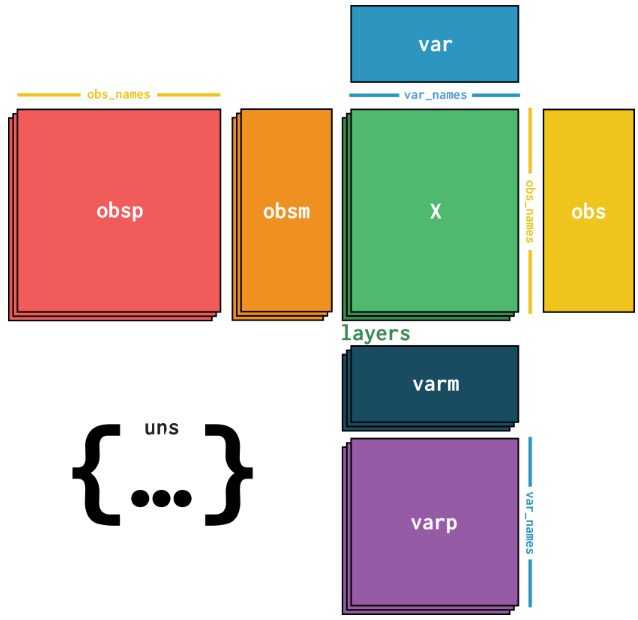

### Здесь мы читаем дааные.
Не стеснейтесь поиграться с объектом  `adata`.

In [5]:
adata = sc.read_h5ad('HumanBrain_NuclAccumb.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 30132 × 59236
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

> Например, что мне делать если я хочу узнать для каждой клетки - из пациента какого пола она пришла:

In [7]:
adata.obs[['sex']].sample(5) # здесь sample это обычный метод pandas df чтобы выбрать случайные строки

,sex
CellID,
10X318_3:GCTTGGGGTTGGACCC,male
10X318_4:GTACAACCAATCAAGA,male
10X318_5:CCTCACAAGGGAGGCA,male
10X318_5:CATGGTAGTTCCTAAG,male
10X318_3:TGACTCCTCGCAGTGC,male


In [ ]:
# ваш код (см. вопросы)

## QC - графики распределений

In [ ]:
# ваш код (см. вопросы)

## Фильтруем данные: убираем дублеты

In [8]:
# # Запускаем Scrublet
sce.pp.scrublet(adata)

In [27]:
# Убираем дубликаты
adata = adata[~adata.obs['predicted_doublet'], :]

## Фильтруем данные: убираем гены и клетки с низким числом каунтов.

In [9]:
# Задайте эти пороги самостоятельно (исходя из графиков выше и вашего настроения)
min_total_counts_per_gene = ...
min_total_counts_per_cell = ...

In [10]:
# Посчитайте суммарное число каунтов на каждую клетку и на каждый ген
cell_counts = ...
gene_counts = ...

In [ ]:
# Делаем фильтрацию
adata = adata[:, gene_counts >= min_total_counts_per_gene]
adata = adata[cell_counts >= min_total_counts_per_cell, :]

### Строим mean-var plot

In [95]:
def plot_mean_var_plot(adata):
    arr = adata.X.toarray()
    mean_expression = arr.mean(axis=0)
    variance_expression = arr.var(axis=0)


    plt.figure(figsize=(3, 3))
    plt.scatter(mean_expression, variance_expression, alpha=0.5)
    plt.title('Mean-var plot')
    plt.xlabel('Mean gene expression')
    plt.ylabel('Gene expression variance')

In [ ]:
plot_mean_var_plot(adata)

### Делаем PCA

In [ ]:
# Считаем PCA
sc.tl.pca(adata)

In [ ]:
# Строим scree-plot. Сколько главных компонент логично использовать?
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [ ]:
# Строим PCA
sc.pl.pca(adata, color=['supercluster_term', 'donor_id'], ncols=1)

### Gene loadings in PCA

In [53]:
def plot_gene_loadings_vs_mean_expression(adata, PC=1):
    mean_expression = np.array(adata.X.mean(axis=0)).flatten()
    pca_loadings = adata.varm['PCs'][:, PC-1]
    
    plt.figure(figsize=(3, 3))
    plt.scatter(mean_expression, pca_loadings, alpha=0.5)
    plt.title(f'PCA Loadings (PC{PC}) vs. Mean Gene Expression')
    plt.xlabel(f'Mean Gene Expression')
    plt.ylabel(f'PCA Loadings (PC{PC})')
    plt.grid(True)
    plt.show()

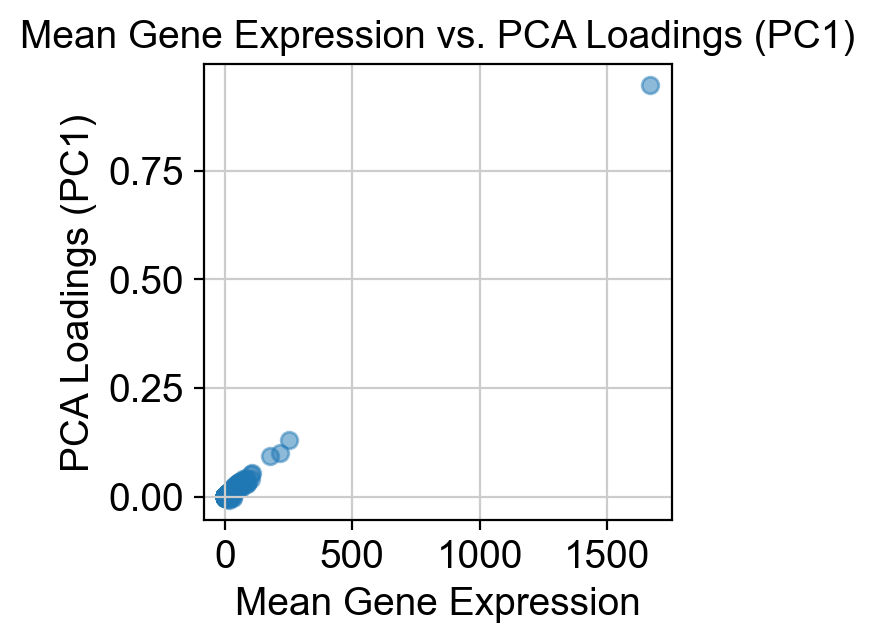

In [54]:
plot_gene_loadings_vs_mean_expression(adata) # у меня получилось так, но у вас может быть по-другому

### Нормализация данных

In [ ]:
# ваш код (см. вопросы)

### Mean-var plot и PCA gene loadings на нормализованных данных

In [ ]:
# ваш код (см. вопросы)

computing PCA
    with n_comps=50
    finished (0:02:47)


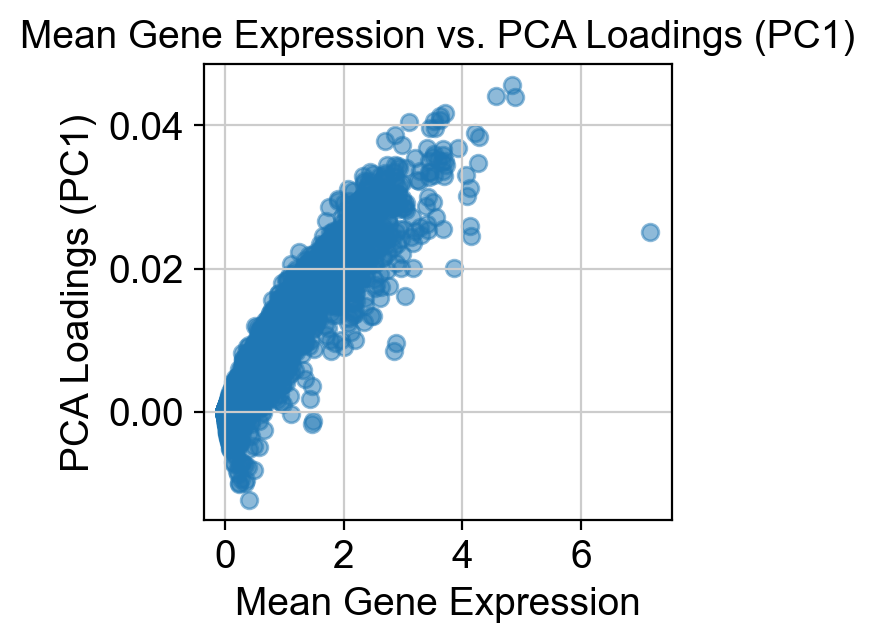

In [55]:
plot_gene_loadings_vs_mean_expression(adata) # у меня получилось так, но у вас может быть по-другому

### UMAP

In [ ]:
# Рассчитываем UMAP
sc.pp.neighbors(adata) # помним, для UMAP нужен kNN-graph!
sc.tl.umap(adata)

In [ ]:
# ваш код (см. вопросы)

### Экспрессия генов

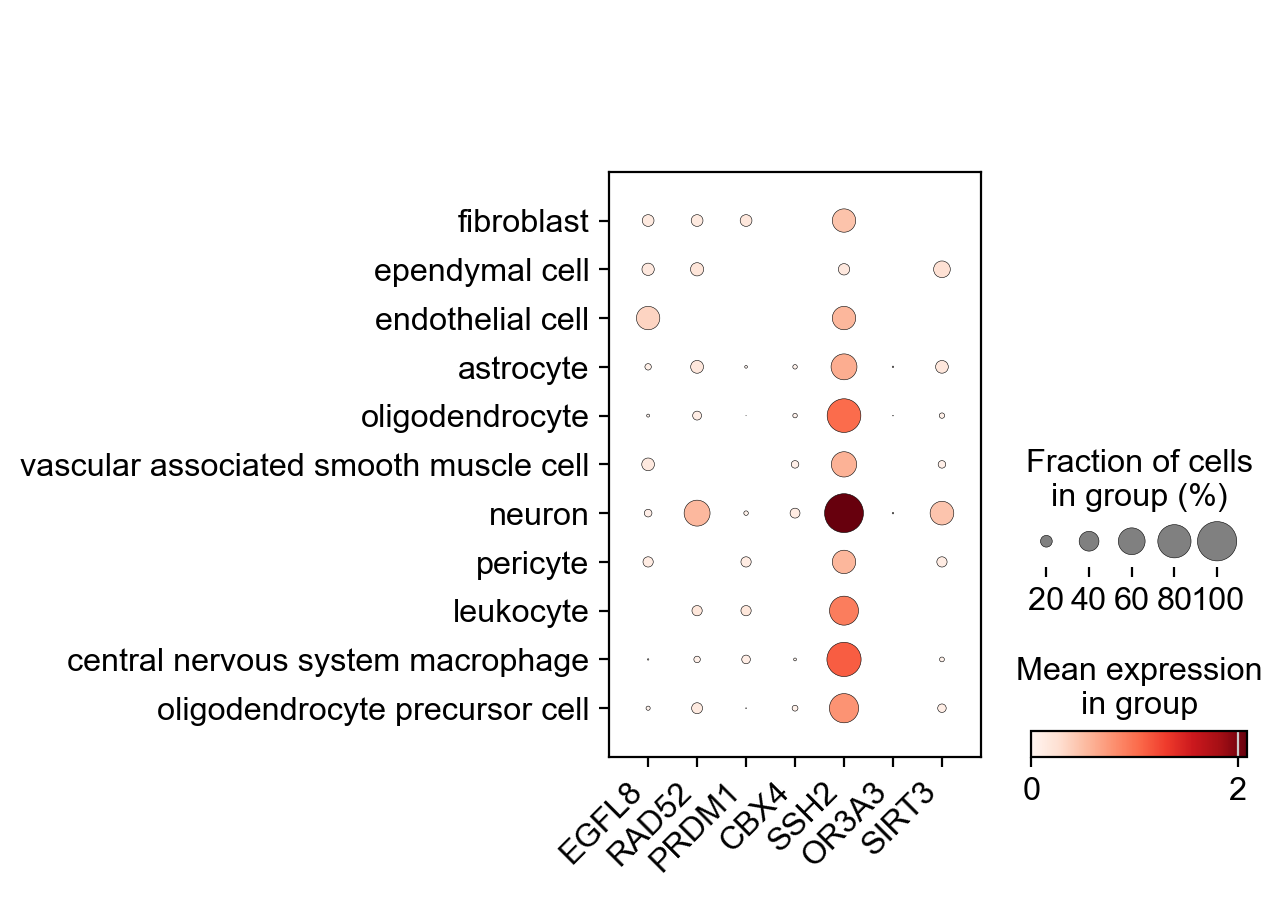

In [161]:
selected_genes = ...
dp = sc.pl.dotplot(adata, selected_genes, 
                   groupby="cell_type", gene_symbols='Gene', 
                   return_fig=True)

# Дополнительные настройки графиков (чтобы было красиво)
ax = dp.get_axes()['mainplot_ax']
ax.tick_params(axis='x', labelrotation=45)
for label in ax.get_xticklabels():
    label.set_ha('right')  # Horizontal alignment